# Beyond this lecture

This last exercise introduces other fields of machine learning beyond multivariate classification.

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys

# Public Data

Our society produces large amounts of data every day. Think about facebook posts, tweets, weather data, mobile radio tower signals, public video surveillance (some cameras provide a webinterface), stock market data,... There are many interesting projects you can create using this data.
Here we use the tweets by @realdonaldtrump from ~2009 until January 2017.

In [2]:
!wget http://ekpwww.ekp.kit.edu/~tkeck/realdonaldtrump.csv

--2017-09-19 00:31:24--  http://ekpwww.ekp.kit.edu/~tkeck/realdonaldtrump.csv
Auflösen des Hostnamens »ekpwww.ekp.kit.edu (ekpwww.ekp.kit.edu)« … 129.13.101.178
Verbindungsaufbau zu ekpwww.ekp.kit.edu (ekpwww.ekp.kit.edu)|129.13.101.178|:80 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: 5954129 (5,7M) [text/csv]
Wird in »»realdonaldtrump.csv«« gespeichert.

realdonaldtrump.csv 100%[===================>]   5,68M   446KB/s    in 13s     

2017-09-19 00:31:37 (450 KB/s) - »»realdonaldtrump.csv«« gespeichert [5954129/5954129]



## Data Mining with Pandas

We already encountered pandas in the previous exercises. The strength of pandas is the exploration of your data, also known as data mining. First we load our dataset. 

**Exercise** Look at the first few entries below and figure out the meaning of each column

In [2]:
import pandas as pd
df = pd.read_csv('realdonaldtrump.csv', parse_dates=[5])
df.head()

favorite_count               source  \
0           17198  Twitter for Android   
1           47078  Twitter for Android   
2           51040  Twitter for Android   
3           51673  Twitter for Android   
4           42993  Twitter for Android   

                                                text in_reply_to_screen_name  \
0  "@zhu_amy3: @realDonaldTrump It's Morning in A...                     NaN   
1  We had a great News Conference at Trump Tower ...                     NaN   
2  Intelligence agencies should never have allowe...                     NaN   
3  I win an election easily, a great "movement" i...                     NaN   
4  Russia has never tried to use leverage over me...                     NaN   

   is_retweet          created_at  retweet_count              id_str  
0        True 2017-01-12 04:24:52           3510  819399723924803585  
1       False 2017-01-12 04:01:38          13591  819393877174087682  
2       False 2017-01-11 12:48:52          17733  819164172781060096  
3       False 2017-01-11 12:44:05          15037  819162968592183298  
4       False 2017-01-11 12:31:31          14087  819159806489591809

As a simple data mining example we look at the sleeping and working pattern of @realdonaldtrump using only the meta-data.
You don't have to understand the code in detail. 

**Exercise** Interpret the plot below

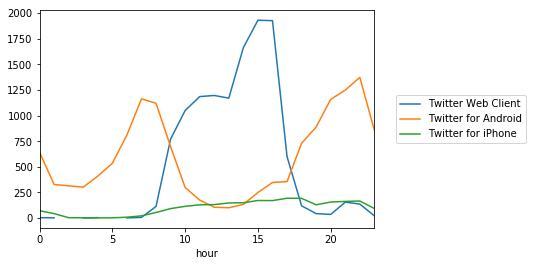

In [20]:
# Localize created_at in New York and add hour as new feature
times = pd.DatetimeIndex(df.created_at).tz_localize('utc').tz_convert('US/Eastern')
df['hour'] = times.hour
df['dayofweek'] = times.dayofweek
# Get the three most common devices in used for the tweets
favorit_devices = df.groupby('source')['id_str'].count().sort_values().index[-3:]
subset = df[df.source.isin(favorit_devices)]
# Count the number of tweets for each device and hour
count = subset.groupby(['source', 'hour'])['id_str'].count()
pivot = count.reset_index().pivot('hour', 'source', values='id_str')
# Plot it
pivot.plot()
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

## Regression

Predicting a real number depending on other variables is called **regression**.

You usually do this if you fit a curve to measured datapoints.
The function form of the curve is usually given by some theory, but you can also use machine learning to fit your datapoints with a "learned" function. Most of the algorithms we discovered so far can also be used for regression.
In particular you can use BDTs and artificial neural networks!

In this example we act as the advisors of @realdonaldtrump. We want to predict how popular a tweet will be. 
To do so we use the "source", "hour", "day of the week", the length of the tweet, the binary feature "is_retweet", the number of @ and # in the tweet and others features. Our goal is to predict the "favorite_count".

As a figure of merit we use the "squared loss". Which is the most commonly used loss function for regression tasks. You use this (if the uncertainties are equal) if you use the $\chi^2$ method.
Beware: "squared loss" is not always the best fom to optimize your objective. E.g. if you want to optimize your costs you probably want to minimize your costs in € and not €$^2$.

In [136]:
import sklearn

source_to_sourceid = dict((s, i) for i, s in enumerate(df['source'].unique()))
df['sourceid'] = df['source'].map(source_to_sourceid)
df['length'] = df.text.str.len()
df['ref_count'] = df.text.str.count('@')
df['hash_count'] = df.text.str.count('#')
df['link_count'] = df.text.str.count('http')

features = ['sourceid', 'dayofweek', 'length', 'ref_count', 'retweet_count', 'link_count', 'hash_count']
target = "favorite_count"

# We use only original tweets
original_df = df[~df.is_retweet]
train, test = original_df[int(len(original_df)//2):], original_df[:int(len(original_df)//2)]

# Predicting the mean value on the training sample is our baseline model.
# We will normalize all achieved losses below to this baseline
baseline_loss = np.mean((train[target].mean() - test[target])**2)
print("Baseline Loss", baseline_loss)

Baseline Loss 429438603.384


### Regression with a BDT

In [137]:
import sklearn.ensemble
bdt = sklearn.ensemble.GradientBoostingRegressor(n_estimators=200, max_depth=5)
bdt.fit(train[features], train[target].values.ravel())
p = bdt.predict(test[features])
print("Loss", np.mean((p - test[target])**2) / baseline_loss)

Loss 0.561339005869


### Feature Importance
We can also look at the importance of each feature.

In [138]:
print("Feature importances")
for f, i in sorted(zip(features, bdt.feature_importances_), key=lambda x: x[1]):
    print(f.ljust(20), i)

Feature importances
link_count           0.00752575730486
hash_count           0.0106702160334
ref_count            0.0300974442708
sourceid             0.0413268400409
dayofweek            0.06566558254
length               0.143528220788
retweet_count        0.701185939022


### Regression with a neural network

Remember that artificial neural networks are universal function approximators?
Therefore it is no problem to do also regression with exactly the same algorithm.
Only the output neuron activation function is different. It is usually a linear (the identity function)
activation instead of a sigmoid shaped function.

In [139]:
import sklearn.neural_network
ann = sklearn.neural_network.MLPRegressor()
ann.fit(train[features], train[target].values.ravel())
p = ann.predict(test[features])
print("Loss", np.mean((p - test[target])**2) / baseline_loss)

Loss 0.533473891833


## Exercise

  * Do you think our model would perform well in practise? Why (not)?
  * Try to remove the most important feature. How good are models now?

# Character based LSTM meets Twitter

The meta-data was already quite interesting. Next, we investigate what we can do with the tweets themselves.
We use **keras**, an easy wrapper around tensorflow, to train an LSTM on the tweets.
This is similar to the example shown in the lecture.

## Preparing the data

We start by converting the tweets into numbers (because neural networks work with numbers).
Each character is replaced by a vector of the form (0,0,0,...,1,...,0,0,0), where the position of the 1 is called the index of the character. This process is called **vectorization**, or **one-hot-encoding**.

Each tweet is split into small chunks, each chunk is represented by a matrix (a series of vectors) $X_i$.
The next character after each chunk is our target $y_i$.

**Exercise** Replace the line
> text = df[~df.is_retweet].text.str.cat(sep=" ")

with 
> text = "Hello "*10

> ...

> print(X, y)

and check if you understood how the transformation of a text into a matrix works.

In [6]:
# Create a large string with all the tweets
text = df[~df.is_retweet].text.str.cat(sep=" ")
# Create maps from characters to indices and vice versa
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# Split the tweets into small fragments
maxlen = 40
step = 3
tweet_fragments = []
next_character = []
for i in range(0, len(text) - maxlen, step):
    tweet_fragments.append(text[i: i + maxlen])
    next_character.append(text[i + maxlen])
    
# Vectorize the fragments, that is replace each character with a boolean-vector
X = np.zeros((len(tweet_fragments), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(tweet_fragments), len(chars)), dtype=np.bool)
for i, tweet_fragment in enumerate(tweet_fragments):
    for t, char in enumerate(tweet_fragment):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_character[i]]] = 1

## Creating a model

We build our model in **keras**. It contains two hidden layers
  * an LSTM layer
  * a fully connected layer

The output layer uses a softmax function, which will estimate the probability of each character to be the next character.
A possible output will look like this (0.1, 0.0, 0.35, ..., 0.1, 0.7, 0.0)

In [9]:
# We restrict ourselves to the first gpu, you can also choose 1,2 and 3.
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

# We avoid allocating the complete memory of the GPU, which is the default behaviour. 
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

import keras
model = keras.models.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(keras.layers.Dense(len(chars)))
model.add(keras.layers.Activation('softmax'))

optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

## Fitting the model

Next we fit the model, using our gpu cluster.
After each iteration (we pass once through the data) we print out a sample text.
The number beta determines the tradeoff between exploitation (take always the character with the highest probability)
and exploration (try out different characters to get some diversity).

In [12]:
for iteration in range(1, 60):
    print('Iteration', iteration)
    model.fit(X, y, batch_size=128, epochs=1)

    sentence = text[:maxlen]
    print('----- Generating with seed: "' + sentence + '"')
    for beta in [5.0, 2.0, 1.0]:
        print('----- beta:', beta)
        sys.stdout.write(sentence)

        x = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x[0, t, char_indices[char]] = 1.

        for i in range(140):
            p = model.predict(x, verbose=0)[0]
            p = p**beta / np.sum(p**beta) - 0.0001
            # Draw a random vector (0,0,...,1,...,0) given the probabilities
            next_index = np.argmax(np.random.multinomial(1, p, 1))
            next_char = indices_char[next_index]
            
            x = np.roll(x, -1, axis=1)
            x[0, -1] = 0.0
            x[0, -1, next_index] = 1.0
            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

Iteration 1
Epoch 1/1
3320/3320 [==============================] - 11s - loss: 3.2194    
----- Generating with seed: "We had a great News Conference at Trump "
----- beta: 5.0
We had a great News Conference at Trump ie ae arer are aire in aa… iaa te t an te ie …e toe aan then an  an ire ara thereec i an at are tore an ie tore an an  an an an ae an iore a
----- beta: 2.0
We had a great News Conference at Trump a  ee aean a  ini wiant ne ar -an  are  ir te aue nin .lmi ane as erelceet Aireswiirelaorecole  outioned onererenie …y ae  ta t wale…are gur
----- beta: 1.0
We had a great News Conference at Trump a ar, oa nearolssc  akebantaTb…eu  e sobihfafeeorrco aprady Pto rintfmla sEredkyntioainc i wsdN:ftemeeofps ehan wr,sprbo heruhrMSSpeie us r 
Iteration 2
Epoch 1/1
3320/3320 [==============================] - 11s - loss: 2.9141    
----- Generating with seed: "We had a great News Conference at Trump "
----- beta: 5.0
We had a great News Conference at Trump the the the the the the the the

KeyboardInterrupt: 

# Exercise

Play around with the given character based model.
Maybe use a different dataset e.g. your PhD thesis you should be working on. Imagine, you could train a neural network which writes the thesis for you. I think this is permitted under KIT rules.